## Image classification with Convolutional Neural Networks


In [97]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [98]:
# This following code is to makesure I have the same env as the one in courese01
import os.path
import sys
HOME = os.path.expanduser('~')
# Using fastai0.7
sys.path.insert(0, HOME +'/fastai/courses/dl1')

In [99]:
# Make sure have the right version of fastai
import fastai
print(sys.modules['fastai'])

<module 'fastai' from '/home/zl2501/fastai/courses/dl1/fastai/__init__.py'>


In [100]:
# This file contains all the main external libs we'll use
from fastai.imports import *

In [101]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

This is to test whether your machine support cuda

In [102]:
torch.cuda.is_available()
torch.backends.cudnn.enabled

True

In [103]:
PATH = HOME + "/fastai/data/dogscats/"
PATH

'/home/zl2501/fastai/data/dogscats/'

## Look at the dataset

In [104]:
os.listdir(PATH)

['tmp', 'models', 'test1', 'train', 'valid', 'sample']

In [105]:
os.listdir(f'{PATH}valid')

['dogs', 'cats']

In [106]:
# only show the first 5
files = os.listdir(f'{PATH}valid/cats')[:5]
files

['cat.4455.jpg',
 'cat.7121.jpg',
 'cat.7657.jpg',
 'cat.11395.jpg',
 'cat.12280.jpg']

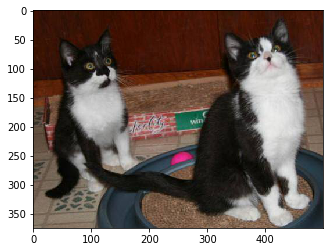

In [107]:
# This is a Python 3.6 format sring which is a convenient way to format a string
img = plt.imread(f'{PATH}valid/cats/{files[4]}')
plt.imshow(img);

In [108]:
# img is a 3 dimensional array (a.k.a. rank 3 tensor)
img.shape

(375, 499, 3)

In [109]:
type(img)

numpy.ndarray

In [110]:
# Show the data of the first 4*4 area of image
img[:4,:4]

array([[[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]],

       [[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]],

       [[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]],

       [[55, 18,  2],
        [55, 18,  2],
        [55, 18,  2],
        [57, 18,  3]]], dtype=uint8)

## Use a pre-trained RESNET34 model

Here we use a pre-trained resnet34 model to start with, instead of building a model from scratch. This model is trained on ImageNet (1.2 million images and 1000 classes). So we can train our model very quickly(under 20 seconds).

resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on [resnet models](https://github.com/KaimingHe/deep-residual-networks).

In [111]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

The first time to run the code, it will take some time to download the pre-trained model. Besides, there is some time to computes and cash the intermediate information.

In [112]:
arch=resnet34
sz = 224
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learning_rate = 0.005
epoch = 5
learn.fit(learning_rate, epoch)

epoch      trn_loss   val_loss   accuracy                      
    0      0.047603   0.027785   0.9885    
    1      0.045879   0.025775   0.99                          
    2      0.041922   0.025104   0.99                          
    3      0.036458   0.026128   0.99                          
    4      0.033755   0.026917   0.9895                        



[array([0.02692]), 0.9895]

## Analyzing results: looking at pictures

In [113]:
type(data)

fastai.dataset.ImageClassifierData

In [114]:
# This is the label for a val data
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [115]:
# from here we know that 'cats' is label 0 and 'dogs' is label 1.
data.classes

['cats', 'dogs']

In [116]:
type(data)

fastai.dataset.ImageClassifierData

In [117]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
# ndarray
log_preds.shape

(2000, 2)

The output represents a prediction for cats, and prediction for dogs.
Here we use `argmax()` to give the actual predicted labels of these images.
The index of the max probability in a single tuple is the actual predicted label the model gives.

In [118]:
# Returns the indices of the maximum values along an axis.
# This is actually giving the predicted labels of these images.
preds = np.argmax(log_preds, axis=1)  
# Caculate the probabilities(0, 1) of dogs from log.
probs = np.exp(log_preds[:,1])

In [119]:
# The predicted labels
preds[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [120]:
# The probability of the dogs
probs[:10]

array([0.00004, 0.00012, 0.00716, 0.00445, 0.00002, 0.00002, 0.00004, 0.00004, 0.77506, 0.0355 ],
      dtype=float32)

### Images with correct and incorrect labels

In [121]:
# Random select
def rand_by_mask(mask, num): 
    return np.random.choice(np.where(mask)[0], min(len(preds), num), replace=False)
# Select images with right labels
def rand_by_correct(is_correct, num =4): 
    return rand_by_mask((preds == data.val_y)==is_correct, num)

In [122]:
# A simple plots function, which overwrite the plots function in module fastai
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [123]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


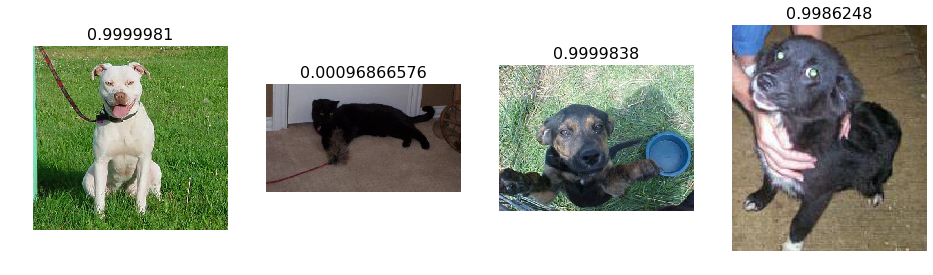

In [124]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True,4), "Correctly classified")

Incorrectly classified
Incorrectly classified
Incorrectly classified


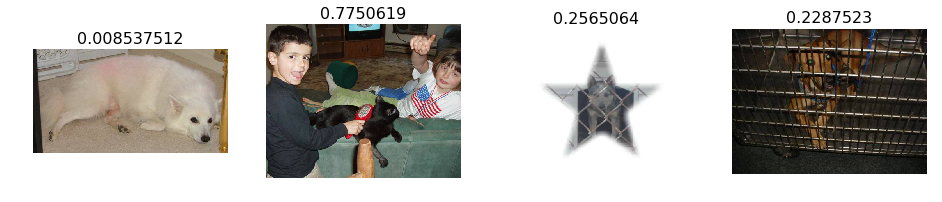

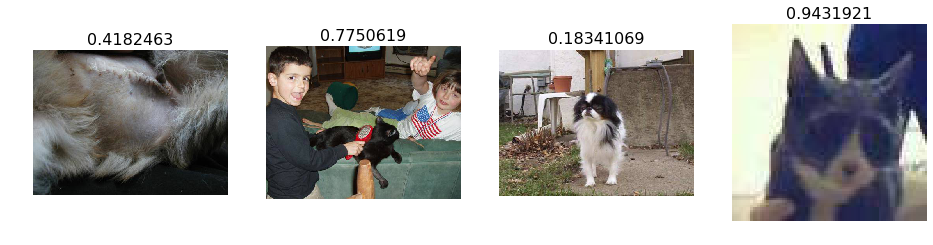

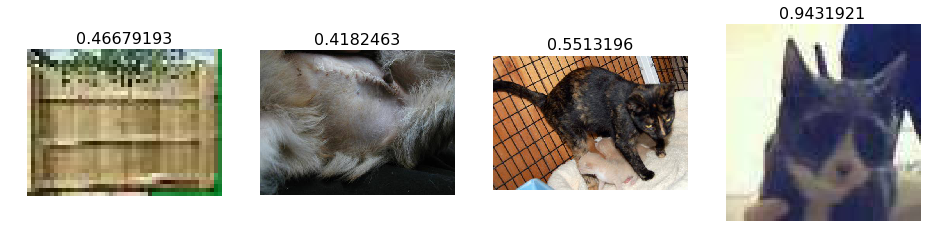

In [125]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False,4), "Incorrectly classified")
plot_val_with_title(rand_by_correct(False,4), "Incorrectly classified")
plot_val_with_title(rand_by_correct(False,4), "Incorrectly classified")

### Most correct and incorrect images 

In [126]:
def most_by_mask(mask, mult, num):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:num]]


def most_by_correct(y, is_correct, num=4): 
    '''
    Use y to determine cat or dog
    '''
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult,num)

Most correct cats


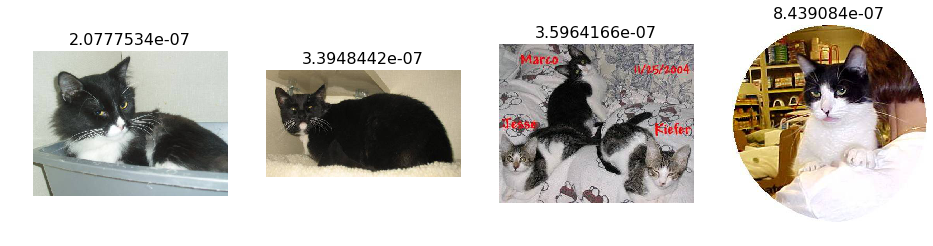

In [127]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


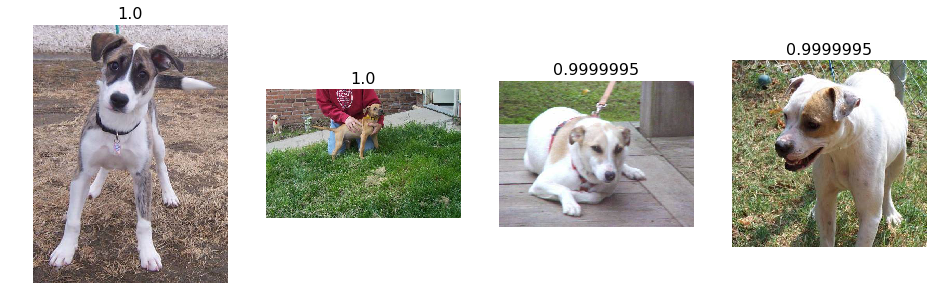

In [128]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


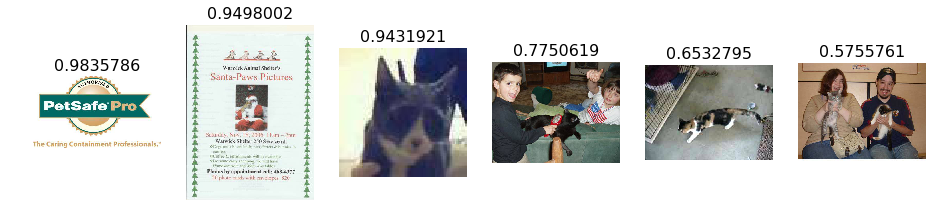

In [129]:
plot_val_with_title(most_by_correct(0, False,6), "Most incorrect cats")

Most incorrect dogs


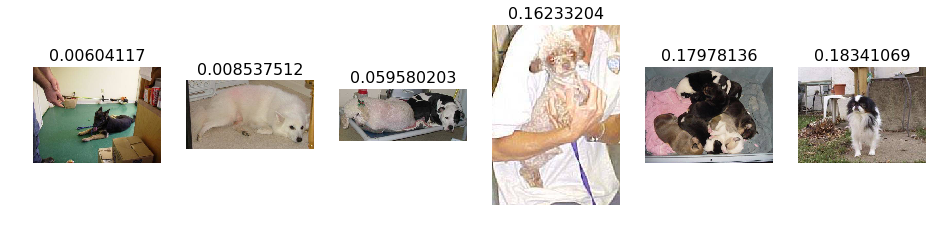

In [130]:
plot_val_with_title(most_by_correct(1, False, 6), "Most incorrect dogs")

## How to choose the learning rate

The method learn.lr_find() helps you find an optimal learning rate. It uses the technique developed in the 2015 paper Cyclical Learning Rates for Training Neural Networks, where we simply keep increasing the learning rate from a very small value, until the loss stops decreasing. We can plot the learning rate across batches to see what this looks like.

In [131]:
learn = ConvLearner.pretrained(arch, data, precompute=True)
lrf=learn.lr_find() 

 73%|███████▎  | 264/360 [00:01<00:01, 92.11it/s, loss=0.109]


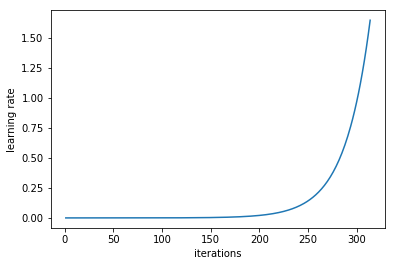

In [132]:
# todo
learn.sched.plot_lr()

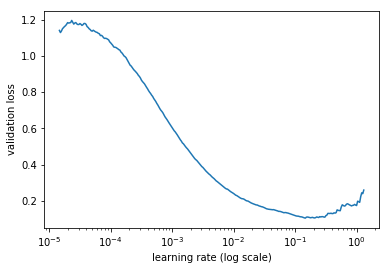

In [133]:
learn.sched.plot()